# *Proposed Policies for Combating Nutritional Deficiencies in Uganda*
### Project 4 Team Wiley

* **Members:** Noah Wadhwani, Chloe Roesslein, Saraya Danielsen, Maxwell Sapp, Nicole Aguilera, Aidan Gauper
* **Collaboration:** Github, Google Drive, Slack

### Project Goals
* Focusing on Uganda families in 2011
* How does demand increase with each individual child? (on average)
* Analyze biggest nutritional deficiencies for Ugandan children
* Design two policies to address nutritional challenges
* Determine costs of policy proposals and suggest who will supplement the costs 

In [2]:
# install:
!pip install CFEDemands --upgrade
!pip install ConsumerDemands
!pip install oauth2client
!pip install eep153_tools
!pip install gnupg
#!pip install dvc

# if needed (read_sheets error)
#!pip install gspread_pandas --upgrade 

  Using cached CFEDemands-0.4.1-py2.py3-none-any.whl (39 kB)
  Using cached ConsumerDemands-0.3.dev0-py2.py3-none-any.whl (12 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
Processing ./.cache/pip/wheels/20/7e/30/7d702acd6a1e89911301cd9dbf9cb9870ca80c0e64bc2cde23/gnupg-2.3.1-py3-none-any.whl


In [3]:
# imports:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Read in Data

In [4]:
# Data for Uganda:
InputFiles = {'Expenditures':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','Expenditures'),
              'Consumption':('1RT5AfbZbWx-CmNaOHLp7aD9qEjgjiBv8lZmPexuKEWg','Consumption'),
              'HH Characteristics':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','HH Characteristics'),
              'FCT': ('1DjpLsyhUbQ-giGcTS_GMrDuW_wG3VDrYH1p-FanKxxs','Codes')}

#### Function to read in sheets:

In [5]:
def get_clean_sheet(key,sheet=None):
    dfs = read_sheets(key)
    if sheet is not None:
        df = dfs[sheet]
    else:
        df = dfs.values()[0] 
    df.columns = [c.strip() for c in df.columns.tolist()]
    df = df.loc[:,~df.columns.duplicated(keep='first')]   
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    df = df.loc[~df.index.duplicated(), :]
    return df

#### Expenditure Table

In [6]:
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)



# We only want data from 2011, as that is our focus year:
x_2011 = x[x.index.isin([2011], level=1)]

# Log of expenditure table (x); 
# log table (y) will be used for later estimation:
y_2011 = np.log(x_2011)

Key available for students@eep153.iam.gserviceaccount.com.


#### Household Characteristics Table

In [7]:
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))


# Focus on 2011
z_2011 = z[z.index.isin([2011], level=1)]

Key available for students@eep153.iam.gserviceaccount.com.


#### Consumption Quantities Table

In [8]:
q = get_clean_sheet(InputFiles['Consumption'][0],
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)


# Focus on 2011
q_2011 = q[q.index.isin([2011], level=1)]

Key available for students@eep153.iam.gserviceaccount.com.


#### Food Conversion Table

In [10]:
fct = get_clean_sheet(InputFiles['FCT'][0],sheet=InputFiles['FCT'][1])

fct.index.name = 'i'
foods = fct['Food description']
fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct['Food description'] = foods
fct = fct.set_index('Food description')

Key available for students@eep153.iam.gserviceaccount.com.


#### Dietary Requirements/Recommended Daily Allowances: Uganda

In [11]:
rda = pd.read_csv("dietary_req.csv").drop(['Source'],axis=1)

# Format for the nutrition section:
rda_index = rda.set_index('Nutrition')

## Population

Originally wanted to compare households **in the same income bracket** with **different numbers of children** to understand how demand of nutrients changes per child added to a household
* BUT: We don’t have income levels, we only have household expenditures
* Does this cause a problem, like if a family of 6 in one income bracket has a similar household expenditure to a family of 6 in a higher income bracket??? 
* If we take the average for each child bracket, the income differences within each bracket will reflect the income differences in the other brackets, so it's still an accurate comparison
* Be really picky about households, make sure they’re actually the exact same breakdown


**Implementation:**
* Create filters
    - Children TOTAL filter
    - Adult TOTAL filter
* Doesn't matter what the breakdown is, as long as children=children and adult=adult for every household in that particular dataset
* We can call any combo of age breakdowns with this system

In [12]:
# Make a column with total count of children, and one with total count of adults:
z_count = z_2011
z_count["Children"], z_count["Adults"] = [(z_2011["M 0-3"] + z_2011["F 0-3"] + 
                                           z_2011["M 4-8"] + z_2011["F 4-8"] +
                                           z_2011["M 9-13"] + z_2011["F 9-13"] +
                                           z_2011["M 14-18"] + z_2011["F 14-18"]),
                                          (z_2011["M 19-30"] + z_2011["F 19-30"] + 
                                           z_2011["M 31-50"] + z_2011["F 31-50"] +
                                           z_2011["M 51+"] + z_2011["F 51+"])]

/tmp/ipykernel_24/2959427395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_count["Children"], z_count["Adults"] = [(z_2011["M 0-3"] + z_2011["F 0-3"] +


In [13]:
# Manually looking at households WITH children and seeing what child/adult breakdowns we're interested in:
filter_kid = z_count["Children"]!=0
z_kids = z_count[filter_kid]
df_analyze = z_kids[['Children', 'Adults']]

# Uncomment to look at it again:
# df_analyze.head(60)

Now what dataframes should we create to focus on? We can do any combination of adults and children in a house;
* _**Focus on houses with just 2 adults**_, as a control measure (and because it's overwhelmingly common)
    - But that could be a bit biased; there are some households with many adults, perhaps multi-family households. These could be more likely to be low-income (living together to support each other), and we are just omitting them from the get-go. Something to note !
* Look at the difference from 2 kids to 3, to 4... all the way up to 6 children

In [14]:
# Filters for children (0 kids to 6 kids):
filter0 = z_count["Children"]==0
filter1 = z_count["Children"]==1
filter2 = z_count["Children"]==2
filter3 = z_count["Children"]==3
filter4 = z_count["Children"]==4
filter5 = z_count["Children"]==5
filter6 = z_count["Children"]==6

# Only 2 adults filter:
filter_adult = z_count["Adults"]==2

In [15]:
# Use filters in different combinations to get different dataframes:
zero_kid = z_count[filter0 & filter_adult]
one_kid = z_count[filter1 & filter_adult]
two_kid = z_count[filter2 & filter_adult]
three_kid = z_count[filter3 & filter_adult]
four_kid = z_count[filter4 & filter_adult]
five_kid = z_count[filter5 & filter_adult]
six_kid = z_count[filter6 & filter_adult]

In [16]:
# Function to get household id numbers from any dataframe
def get_ids(df):
    multiple_list = list(df.index.values)
    return [i[0] for i in multiple_list]


# Function to get total expenditures of any dataframe
def get_total_exp(df):
    return (df.sum(axis = 1)).to_frame('Total Exp').droplevel(level=[1,2])
# get rid of droplevel ^ if that ends up being a matching problem


# Function to get a total average expenditure for all households, for a dataframe like that ^
def average_exp(df):
    list_exp = df['Total Exp'].tolist()
    return sum(list_exp)/len(list_exp)

### Getting Household Dataframes (0 kids - 6 kids):

In [17]:
# 0 children, 2 adult households:
# Pull a list of household ID's from the initial family breakdowns:
# (we will use a more refined ID list once we know what households to drop for having all NaN expenditure values)
zero_kid_rough_ids = get_ids(zero_kid)
# Getting expenditure dataframe just for this family breakdown, and dropping the ones with no expenditure data:
zero_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(zero_kid_rough_ids)]).dropna(axis=0, how='all')
# TOTAL sum expenditure per household:
zero_kid_total_x = get_total_exp(zero_kid_x)
zero_kid_ids = get_ids(zero_kid_x)


# Do the same for each household breakdown:


# 1 child, 2 adult:
one_kid_rough_ids = get_ids(one_kid)
one_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(one_kid_rough_ids)]).dropna(axis=0, how='all')
one_kid_total_x = get_total_exp(one_kid_x)
one_kid_ids = get_ids(one_kid_x)

# 2 child, 2 adult:
two_kid_rough_ids = get_ids(two_kid)
two_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(two_kid_rough_ids)]).dropna(axis=0, how='all')
two_kid_total_x = get_total_exp(two_kid_x)
two_kid_ids = get_ids(two_kid_x)

# 3 child, 2 adult:
three_kid_rough_ids = get_ids(three_kid)
three_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(three_kid_rough_ids)]).dropna(axis=0, how='all')
three_kid_total_x = get_total_exp(three_kid_x)
three_kid_ids = get_ids(three_kid_x)

# 4 child, 2 adult:
four_kid_rough_ids = get_ids(four_kid)
four_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(four_kid_rough_ids)]).dropna(axis=0, how='all')
four_kid_total_x = get_total_exp(four_kid_x)
four_kid_ids = get_ids(four_kid_x)

# 5 child, 2 adult:
five_kid_rough_ids = get_ids(five_kid)
five_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(five_kid_rough_ids)]).dropna(axis=0, how='all')
five_kid_total_x = get_total_exp(five_kid_x)
five_kid_ids = get_ids(five_kid_x)

# 6 child, 2 adult:
six_kid_rough_ids = get_ids(six_kid)
six_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(six_kid_rough_ids)]).dropna(axis=0, how='all')
six_kid_total_x = get_total_exp(six_kid_x)
six_kid_ids = get_ids(six_kid_x)

# See if there's a similar amount of data on each breakdown:
print('Number of 0 child/2 adult households WITH expenditure data: ', len(zero_kid_x), ',\n', 
      '1 child/2 adult households:', len(one_kid_x), ',\n',
      '2 child/2 adult households:', len(two_kid_x), ',\n', 
      '3 child/2 adult households:', len(three_kid_x), ',\n', 
      '4 child/2 adult households:', len(four_kid_x), ',\n', 
      '5 child/2 adult households:', len(five_kid_x), ',\n', 
      '6 child/2 adult households:', len(six_kid_x), ',\n')

Number of 0 child/2 adult households WITH expenditure data:  80 ,
 1 child/2 adult households: 142 ,
 2 child/2 adult households: 190 ,
 3 child/2 adult households: 226 ,
 4 child/2 adult households: 216 ,
 5 child/2 adult households: 184 ,
 6 child/2 adult households: 108 ,



### Average Expenditure Per Week (based on number of children)

In [149]:
exp_data = {'Num Kids':[0, 1, 2, 3, 4, 5, 6],
        'Avg Weekly Expenditure (UGX)':[average_exp(zero_kid_total_x), average_exp(one_kid_total_x), average_exp(two_kid_total_x), average_exp(three_kid_total_x), average_exp(four_kid_total_x), average_exp(five_kid_total_x), average_exp(six_kid_total_x)]}

exp_table = pd.DataFrame(exp_data)


In [150]:
exp_table

,Num Kids,Avg Weekly Expenditure (UGX)
0,0,21588.062500
1,1,27643.239437
2,2,26814.578947
3,3,25776.360619
4,4,26222.893519
5,5,29320.538043
6,6,30356.111111


In [151]:
# Conversion for picturing it better: 
# 1 UGX = 0.000282670 USD

exp_table['Avg Weekly Expenditure (USD)'] = exp_table['Avg Weekly Expenditure (UGX)']*0.000282413

#### Conversions to USD for Context:

In [152]:
exp_table

,Num Kids,Avg Weekly Expenditure (UGX),Avg Weekly Expenditure (USD)
0,0,21588.062500,6.096749
1,1,27643.239437,7.806810
2,2,26814.578947,7.572786
3,3,25776.360619,7.279579
4,4,26222.893519,7.405686
5,5,29320.538043,8.280501
6,6,30356.111111,8.572960


## Picturing Average Expenditure per Week

Text(0, 0.5, 'Average Household Expenditure (in UGX)')

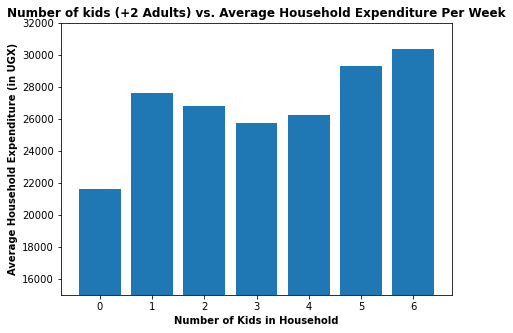

In [153]:
num_kids = exp_table['Num Kids'].to_list()
exp = exp_table['Avg Weekly Expenditure (UGX)'].to_list()
 
# Figure Size
fig, ax = plt.subplots(figsize =(7, 5))
 
# Horizontal Bar Plot
ax.bar(num_kids, exp)

ax.set_title('Number of kids (+2 Adults) vs. Average Household Expenditure Per Week', fontweight='bold', fontsize=12)

ax.set_ylim([15000, 32000])

plt.xlabel('Number of Kids in Household', fontweight='bold')
plt.ylabel('Average Household Expenditure (in UGX)', fontweight='bold')


# [A] Estimate Demand System

* Not going to do 7 different demand comparisons for each dataframe
* Just look at a few increments of increasing children: 
* 1 child --> 3 children --> 5 children

In [154]:
one_kid_z = (z_2011[z_2011.index.get_level_values('j').isin(one_kid_ids)]).drop(['Children', 'Adults'], axis=1)
one_kid_y = np.log(one_kid_x)

three_kid_z = (z_2011[z_2011.index.get_level_values('j').isin(three_kid_ids)]).drop(['Children', 'Adults'], axis=1)
three_kid_y = np.log(three_kid_x)

five_kid_z = (z_2011[z_2011.index.get_level_values('j').isin(five_kid_ids)]).drop(['Children', 'Adults'], axis=1)
five_kid_y = np.log(five_kid_x)

In [155]:
# Create these for later nutritional section:
# (it's the same thing, but with age labels that will later match the RDA age labels):

one_kid_z_rda = one_kid_z
one_kid_z_rda['C 1-3'] = one_kid_z['M 0-3'] + one_kid_z['F 0-3']
one_kid_z_rda = one_kid_z_rda.drop(['M 0-3', 'F 0-3'], axis=1)

five_kid_z_rda = five_kid_z
five_kid_z_rda['C 1-3'] = five_kid_z['M 0-3'] + five_kid_z['F 0-3']
five_kid_z_rda = five_kid_z_rda.drop(['M 0-3', 'F 0-3'], axis=1)

In [194]:
# Create reduced form
import cfe
result_one = cfe.Result(y=one_kid_y, z=one_kid_z)
result_three = cfe.Result(y=three_kid_y, z=three_kid_z)
result_five = cfe.Result(y=five_kid_y, z=five_kid_z)

# For later nutritional section:
result_one_rda = cfe.Result(y=one_kid_y, z=one_kid_z_rda)
result_five_rda = cfe.Result(y=five_kid_y, z=five_kid_z_rda)

In [195]:
# run this to be able to run the next few lines:
result_one.get_reduced_form()
result_three.get_reduced_form()
result_five.get_reduced_form()

# For later nutritional section:
result_one_rda.get_reduced_form()
result_five_rda.get_reduced_form()

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (2011, 1)
  warnings.warn("No variation in: %s" % str(constant))
/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:457: RuntimeWarning: invalid value encountered in sqrt
  sed[Item]=pd.Series(np.sqrt(np.diag(V[Item])), index=z.columns) # reduced form se on characteristics


## Delta Values

#### ONE CHILD HOUSEHOLDS:

In [158]:
result_one.delta.to_dataframe().unstack('k')

delta                                            \
k                   M 0-3         M 4-8        M 9-13       M 14-18   
i                                                                     
cooking oil  2.353377e+13 -2.499270e+13 -2.499270e+13 -2.499270e+13   
fresh milk  -4.230100e+14 -1.523265e+14 -1.523265e+14 -1.523265e+14   
maize flour -6.939774e+13 -4.975005e+12 -4.975005e+12 -4.975005e+12   
onions       1.999629e+14 -8.780523e+13 -8.780523e+13 -8.780523e+13   
rice        -1.482347e+14 -2.077120e+13 -2.077120e+13 -2.077120e+13   
salt         7.450167e+12 -5.962752e+10 -5.962752e+10 -5.962752e+10   
sugar        6.336563e+13 -3.875900e+12 -3.875900e+12 -3.875900e+12   
tea         -4.171579e+14 -9.172445e+13 -9.172445e+13 -9.172445e+13   
tomatoes    -3.386867e+14  4.335653e+13  4.335653e+13  4.335653e+13   

                                                                     \
k                 M 19-30       M 31-50         M 51+         F 0-3   
i                                                                     
cooking oil -8.073064e+13 -8.073064e+13 -8.073064e+13  2.353377e+13   
fresh milk  -1.099183e+15 -1.099183e+15 -1.099183e+15 -4.230100e+14   
maize flour -2.179819e+13 -2.179819e+13 -2.179819e+13 -6.939774e+13   
onions      -2.892242e+14 -2.892242e+14 -2.892242e+14  1.999629e+14   
rice        -5.085441e+14 -5.085441e+14 -5.085441e+14 -1.482347e+14   
salt        -3.498686e+13 -3.498686e+13 -3.498686e+13  7.450167e+12   
sugar        6.444994e+11  6.444994e+11  6.444994e+11  6.336563e+13   
tea         -2.822634e+14 -2.822634e+14 -2.822634e+14 -4.171579e+14   
tomatoes    -1.533046e+14 -1.533046e+14 -1.533046e+14 -3.386867e+14   

                                                                     \
k                   F 4-8        F 9-13       F 14-18       F 19-30   
i                                                                     
cooking oil -2.499270e+13 -2.499270e+13 -2.499270e+13 -8.073064e+13   
fresh milk  -1.523265e+14 -1.523265e+14 -1.523265e+14 -1.099183e+15   
maize flour -4.975005e+12 -4.975005e+12 -4.975005e+12 -2.179819e+13   
onions      -8.780523e+13 -8.780523e+13 -8.780523e+13 -2.892242e+14   
rice        -2.077120e+13 -2.077120e+13 -2.077120e+13 -5.085441e+14   
salt        -5.962752e+10 -5.962752e+10 -5.962752e+10 -3.498686e+13   
sugar       -3.875900e+12 -3.875900e+12 -3.875900e+12  6.444994e+11   
tea         -9.172445e+13 -9.172445e+13 -9.172445e+13 -2.822634e+14   
tomatoes     4.335653e+13  4.335653e+13  4.335653e+13 -1.533046e+14   

                                                       
k                 F 31-50         F 51+         C 1-3  
i                                                      
cooking oil -8.073064e+13 -8.073064e+13 -4.852647e+13  
fresh milk  -1.099183e+15 -1.099183e+15  2.706836e+14  
maize flour -2.179819e+13 -2.179819e+13  6.442273e+13  
onions      -2.892242e+14 -2.892242e+14 -2.877681e+14  
rice        -5.085441e+14 -5.085441e+14  1.274635e+14  
salt        -3.498686e+13 -3.498686e+13 -7.509794e+12  
sugar        6.444994e+11  6.444994e+11 -6.724153e+13  
tea         -2.822634e+14 -2.822634e+14  3.254335e+14  
tomatoes    -1.533046e+14 -1.533046e+14  3.820432e+14

#### THREE CHILD HOUSEHOLDS:

In [159]:
result_three.delta.to_dataframe().unstack('k')

delta                                            \
k                   M 0-3         M 4-8        M 9-13       M 14-18   
i                                                                     
beans dry    2.742145e+14  2.742145e+14  2.742145e+14  2.742145e+14   
beef         1.743964e+14  1.743964e+14  1.743964e+14  1.743964e+14   
cooking oil -2.647386e+14 -2.647386e+14 -2.647386e+14 -2.647386e+14   
maize flour -6.407830e+13 -6.407830e+13 -6.407830e+13 -6.407830e+13   
onions      -1.384681e+14 -1.384681e+14 -1.384681e+14 -1.384681e+14   
salt        -6.291631e+12 -6.291631e+12 -6.291631e+12 -6.291631e+12   
sugar        1.685873e+14  1.685873e+14  1.685873e+14  1.685873e+14   
tea         -1.575484e+14 -1.575484e+14 -1.575484e+14 -1.575484e+14   
tomatoes     8.709451e+12  8.709451e+12  8.709451e+12  8.709451e+12   

                                                                     \
k                 M 19-30       M 31-50         M 51+         F 0-3   
i                                                                     
beans dry   -1.726819e+14 -1.726819e+14 -1.726819e+14  2.742145e+14   
beef         1.142979e+13  1.142979e+13  1.142979e+13  1.743964e+14   
cooking oil  1.346833e+14  1.346833e+14  1.346833e+14 -2.647386e+14   
maize flour -1.150621e+13 -1.150621e+13 -1.150621e+13 -6.407830e+13   
onions       6.234683e+13  6.234683e+13  6.234683e+13 -1.384681e+14   
salt         8.248470e+13  8.248470e+13  8.248470e+13 -6.291631e+12   
sugar       -1.276775e+12 -1.276775e+12 -1.276775e+12  1.685873e+14   
tea          6.454712e+13  6.454712e+13  6.454712e+13 -1.575484e+14   
tomatoes     1.116199e+13  1.116199e+13  1.116199e+13  8.709451e+12   

                                                                     \
k                   F 4-8        F 9-13       F 14-18       F 19-30   
i                                                                     
beans dry    2.742145e+14  2.742145e+14  2.742145e+14 -1.726819e+14   
beef         1.743964e+14  1.743964e+14  1.743964e+14  1.142979e+13   
cooking oil -2.647386e+14 -2.647386e+14 -2.647386e+14  1.346833e+14   
maize flour -6.407830e+13 -6.407830e+13 -6.407830e+13 -1.150621e+13   
onions      -1.384681e+14 -1.384681e+14 -1.384681e+14  6.234683e+13   
salt        -6.291631e+12 -6.291631e+12 -6.291631e+12  8.248470e+13   
sugar        1.685873e+14  1.685873e+14  1.685873e+14 -1.276775e+12   
tea         -1.575484e+14 -1.575484e+14 -1.575484e+14  6.454712e+13   
tomatoes     8.709451e+12  8.709451e+12  8.709451e+12  1.116199e+13   

                                         
k                 F 31-50         F 51+  
i                                        
beans dry   -1.726819e+14 -1.726819e+14  
beef         1.142979e+13  1.142979e+13  
cooking oil  1.346833e+14  1.346833e+14  
maize flour -1.150621e+13 -1.150621e+13  
onions       6.234683e+13  6.234683e+13  
salt         8.248470e+13  8.248470e+13  
sugar       -1.276775e+12 -1.276775e+12  
tea          6.454712e+13  6.454712e+13  
tomatoes     1.116199e+13  1.116199e+13

#### FIVE CHILD HOUSEHOLDS:

In [160]:
result_three.delta.to_dataframe().unstack('k')

delta                                            \
k                   M 0-3         M 4-8        M 9-13       M 14-18   
i                                                                     
beans dry    2.742145e+14  2.742145e+14  2.742145e+14  2.742145e+14   
beef         1.743964e+14  1.743964e+14  1.743964e+14  1.743964e+14   
cooking oil -2.647386e+14 -2.647386e+14 -2.647386e+14 -2.647386e+14   
maize flour -6.407830e+13 -6.407830e+13 -6.407830e+13 -6.407830e+13   
onions      -1.384681e+14 -1.384681e+14 -1.384681e+14 -1.384681e+14   
salt        -6.291631e+12 -6.291631e+12 -6.291631e+12 -6.291631e+12   
sugar        1.685873e+14  1.685873e+14  1.685873e+14  1.685873e+14   
tea         -1.575484e+14 -1.575484e+14 -1.575484e+14 -1.575484e+14   
tomatoes     8.709451e+12  8.709451e+12  8.709451e+12  8.709451e+12   

                                                                     \
k                 M 19-30       M 31-50         M 51+         F 0-3   
i                                                                     
beans dry   -1.726819e+14 -1.726819e+14 -1.726819e+14  2.742145e+14   
beef         1.142979e+13  1.142979e+13  1.142979e+13  1.743964e+14   
cooking oil  1.346833e+14  1.346833e+14  1.346833e+14 -2.647386e+14   
maize flour -1.150621e+13 -1.150621e+13 -1.150621e+13 -6.407830e+13   
onions       6.234683e+13  6.234683e+13  6.234683e+13 -1.384681e+14   
salt         8.248470e+13  8.248470e+13  8.248470e+13 -6.291631e+12   
sugar       -1.276775e+12 -1.276775e+12 -1.276775e+12  1.685873e+14   
tea          6.454712e+13  6.454712e+13  6.454712e+13 -1.575484e+14   
tomatoes     1.116199e+13  1.116199e+13  1.116199e+13  8.709451e+12   

                                                                     \
k                   F 4-8        F 9-13       F 14-18       F 19-30   
i                                                                     
beans dry    2.742145e+14  2.742145e+14  2.742145e+14 -1.726819e+14   
beef         1.743964e+14  1.743964e+14  1.743964e+14  1.142979e+13   
cooking oil -2.647386e+14 -2.647386e+14 -2.647386e+14  1.346833e+14   
maize flour -6.407830e+13 -6.407830e+13 -6.407830e+13 -1.150621e+13   
onions      -1.384681e+14 -1.384681e+14 -1.384681e+14  6.234683e+13   
salt        -6.291631e+12 -6.291631e+12 -6.291631e+12  8.248470e+13   
sugar        1.685873e+14  1.685873e+14  1.685873e+14 -1.276775e+12   
tea         -1.575484e+14 -1.575484e+14 -1.575484e+14  6.454712e+13   
tomatoes     8.709451e+12  8.709451e+12  8.709451e+12  1.116199e+13   

                                         
k                 F 31-50         F 51+  
i                                        
beans dry   -1.726819e+14 -1.726819e+14  
beef         1.142979e+13  1.142979e+13  
cooking oil  1.346833e+14  1.346833e+14  
maize flour -1.150621e+13 -1.150621e+13  
onions       6.234683e+13  6.234683e+13  
salt         8.248470e+13  8.248470e+13  
sugar       -1.276775e+12 -1.276775e+12  
tea          6.454712e+13  6.454712e+13  
tomatoes     1.116199e+13  1.116199e+13

## Alpha Values

#### ONE CHILD HOUSEHOLDS:

In [161]:
result_one.a.to_dataframe().unstack('i')

a                                                          \
i        cooking oil    fresh milk   maize flour        onions          rice   
t    m                                                                         
2011 1  1.864540e+14  2.350692e+15  4.857138e+13  6.662537e+14  1.037859e+15   

                                                                
i               salt         sugar           tea      tomatoes  
t    m                                                          
2011 1  7.003334e+13  2.586901e+12  6.562513e+14  2.632526e+14

#### THREE CHILD HOUSEHOLDS:

In [162]:
result_three.a.to_dataframe().unstack('i')

a                                                          \
i          beans dry          beef   cooking oil   maize flour        onions   
t    m                                                                         
2011 1 -4.772796e+14 -5.460487e+14  5.248491e+14  2.152473e+14  2.907106e+14   

                                                                
i               salt         sugar           tea      tomatoes  
t    m                                                          
2011 1 -1.460945e+14 -5.032084e+14  3.435509e+14 -4.845234e+13

#### FIVE CHILD HOUSEHOLDS:

In [163]:
result_five.a.to_dataframe().unstack('i')

a                                                        \
i        cooking oil    fresh milk maize flour        onions          salt   
t    m                                                                       
2011 1  5.140478e+14 -9.924635e+13    8.595182 -1.057878e+14 -2.845727e+14   

                                              
i          sugar           tea      tomatoes  
t    m                                        
2011 1  8.092635  1.251579e+13 -1.763267e+15

## Beta Values

#### ONE CHILD HOUSEHOLDS:

In [164]:
beta_one = result_one.get_beta(as_df=True)
beta_one

i
cooking oil    0.276988
fresh milk     0.878805
maize flour    0.162547
onions         0.431445
rice           0.277559
salt           0.150961
sugar          0.274514
tea            0.426405
tomatoes       0.509624
Name: beta, dtype: float64

#### THREE CHILD HOUSEHOLDS:

In [165]:
beta_three = result_three.get_beta(as_df=True)
beta_three

i
beans dry      0.023871
beef           0.048439
cooking oil    0.451476
maize flour   -0.453853
onions         0.592390
salt           0.002226
sugar          0.342707
tea            0.429852
tomatoes       0.461831
Name: beta, dtype: float64

#### FIVE CHILD HOUSEHOLDS:

In [166]:
beta_five = result_five.get_beta(as_df=True)
beta_five

i
cooking oil    0.020363
fresh milk    -0.681285
maize flour    0.823666
onions         0.148437
salt           0.138694
sugar         -0.203669
tea            0.454712
tomatoes       0.220498
Name: beta, dtype: float64

## Visualize Some Demand:

We are curious to look specifically at:
* Maize flour 
* Tomatoes
* Tea

But we will investigate each item possible, and see what we find.

In [167]:
# Put demand values into dataframes to pull from by name of good:
beta_one_df = beta_one.to_frame().reset_index().rename(columns= {'i': 'good'})
beta_three_df = beta_three.to_frame().reset_index().rename(columns= {'i': 'good'})
beta_five_df = beta_five.to_frame().reset_index().rename(columns= {'i': 'good'})

In [168]:
# Create a dataframe to compare beta values for a single good for all household breakdowns:
def beta_df(good):
    values = []
    for df in [beta_one_df, beta_three_df, beta_five_df]:
        values.append(df[df['good'] == good].iloc[0]['beta'])
    return pd.DataFrame([[1, values[0]], [3, values[1]], [5, values[2]]], columns = ['Children', 'Beta'])

In [169]:
# Make df for each good
maize_flour_beta = beta_df('maize flour')
tomatoes_beta = beta_df('tomatoes')
tea_beta = beta_df('tea')
cooking_oil_beta = beta_df('cooking oil')
onions_beta = beta_df('onions')
salt_beta = beta_df('salt')
sugar_beta = beta_df('sugar')

In [170]:
# Function to make a bar graph for any inputted good:
def make_beta_bar(df, good):
    children = df['Children'].to_list()
    betas = df['Beta'].to_list()
    
    # Figure Size
    fig, ax = plt.subplots(figsize =(4.5, 4.5))
    
    # Add a line between positive and negative values
    x1, y1 = [0, 6], [0, 0]
    plt.plot(x1, y1, marker = 'o')
    
    # For color-coding whether demand is positive or negative demand:
    col = []
    for val in betas:
        if val < 0:
            col.append('red')
        else:
            col.append('green')
    
    plt.bar(children, betas, color = col)

    ax.set_ylim([-0.5, 0.8])

    ax.set_title('Number of kids vs. Beta Value for ' + good, fontweight='bold', fontsize=10)
    plt.xlabel('Number of Kids', fontweight='bold')
    plt.ylabel('Beta Values for ' + good, fontweight='bold')
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

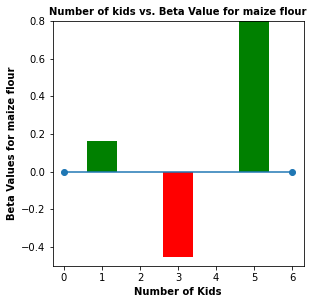

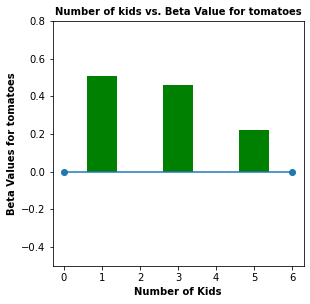

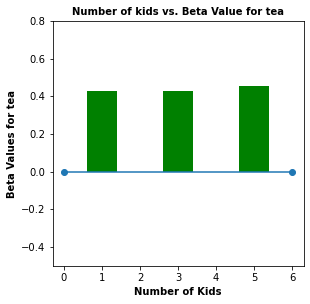

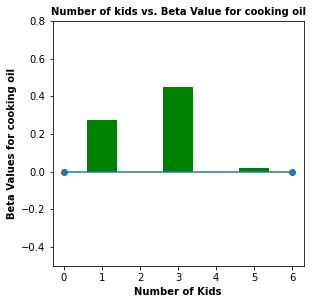

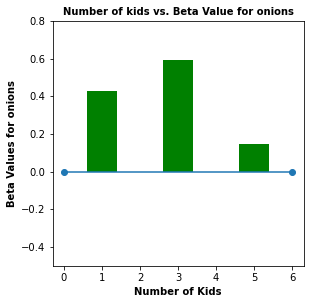

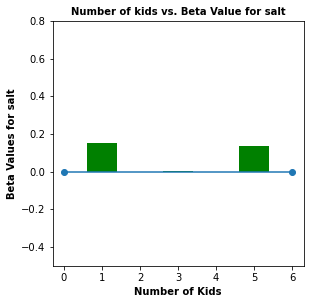

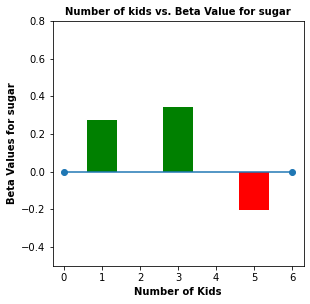

In [171]:
make_beta_bar(maize_flour_beta, 'maize flour')
make_beta_bar(tomatoes_beta, 'tomatoes')
make_beta_bar(tea_beta, 'tea')

make_beta_bar(cooking_oil_beta, 'cooking oil')
make_beta_bar(onions_beta, 'onions')
make_beta_bar(salt_beta, 'salt')
make_beta_bar(sugar_beta, 'sugar')

# [A] Construct Nutrient System

If you can describe quantities demanded as a function of prices, budgets, and household characteristics, and map quantities into nutrients, then you can also describe a system of nutrients as a function of the same variables.

## Nutritional requirements

Individuals have nutritional requirements established by nutrition
scientists. 

### Nutritional Needs of individuals

#### Recommended Daily Allowances: Uganda

In [114]:
rda

,Nutrition,C 1-3,F 4-8,M 4-8,F 9-13,M 9-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
0,Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
1,Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
2,"Fiber, total dietary",14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
3,"Folate, DFE",150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
4,"Calcium, Ca",700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
5,"Carbohydrate, by difference",130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
6,"Iron, Fe",7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
7,"Magnesium, Mg",80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
8,Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0
9,"Phosphorus, P",460.0,500.0,500.0,1250.0,1250.0,1250.0,1250.0,700.0,700.0,700.0,700.0,700.0,700.0


### Nutritional Needs of Households

Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household, the number of different kinds of people can be computed by averaging over households:

#### Start with 5 children households; then go to 1 child households (to compare)

In [172]:
result_five_rda.k

<xarray.DataArray 'k' (k: 13)>
array(['M 4-8', 'M 9-13', 'M 14-18', 'M 19-30', 'M 31-50', 'M 51+', 'F 4-8',
       'F 9-13', 'F 14-18', 'F 19-30', 'F 31-50', 'F 51+', 'C 1-3'],
      dtype='<U7')
Coordinates:
  * k        (k) <U7 'M 4-8' 'M 9-13' 'M 14-18' ... 'F 31-50' 'F 51+' 'C 1-3'

In [173]:
result_five_rda.coords['i']

<xarray.DataArray 'i' (i: 8)>
array(['cooking oil', 'fresh milk', 'maize flour', 'onions', 'salt', 'sugar',
       'tea', 'tomatoes'], dtype='<U11')
Coordinates:
  * i        (i) <U11 'cooking oil' 'fresh milk' ... 'tea' 'tomatoes'

In [176]:
# In first round, averaged over households and villages

zbar_five = result_five_rda.z.sel(t=result_five_rda.firstround,drop=True).mean(['j','m']).squeeze()
zbar_five = zbar_five.to_dataframe().squeeze()
zbar_five

k
M 4-8      0.820652
M 9-13     0.722826
M 14-18    0.375000
M 19-30    0.146739
M 31-50    0.706522
M 51+      0.092391
F 4-8      0.864130
F 9-13     0.750000
F 14-18    0.396739
F 19-30    0.445652
F 31-50    0.538043
F 51+      0.070652
C 1-3      1.070652
Name: z, dtype: float64

Now, the inner/dot/matrix product between `zbar` and the `rda`
DataFrame of requirements will give us minimum requirements for the
average household:

In [181]:
# May need to tweak types or alignment to match RDA and zbar types:
rda_five0,zbar_five0=rda_index.align(zbar_five,axis=1)

# This matrix product gives minimum nutrient requirements for average household
# MISSING VALUES ARE NaN, NOT BLANK; use .fillna(0) instead
hh_rda_five = rda_five0.fillna(0)@zbar_five0

# RDA is /daily/, but  demands in Uganda data are /weekly/:
hh_rda_five = hh_rda_five*7
hh_rda_five


Nutrition
Energy                             79526.086957
Protein                             1646.483696
Fiber, total dietary                1113.365217
Folate, DFE                        14336.684783
Calcium, Ca                        51564.130435
Carbohydrate, by difference         6370.000000
Iron, Fe                             504.266304
Magnesium, Mg                      11773.315217
Niacin                               553.152174
Phosphorus, P                      38784.184783
Potassium, K                      204883.152174
Riboflavin                            43.015761
Thiamin                               42.091304
Vitamin A, RAE                     28582.065217
Vitamin B-12                          86.020109
Vitamin B-6                           46.435870
Vitamin C, total ascorbic acid      2397.880435
Vitamin E (alpha-tocopherol)         531.961957
Vitamin K (phylloquinone)           3355.815217
Zinc, Zn                             349.657609
Sodium, Na                    

#### Now to 1-child households

In [ ]:
result_one_rda

In [198]:
# In first round, averaged over households and villages

zbar_one = result_one_rda.z.sel(t=result_one_rda.firstround,drop=True).mean(['j','m']).squeeze()
zbar_one = zbar_one.to_dataframe().squeeze()
zbar_one


k
M 4-8      0.056338
M 9-13     0.070423
M 14-18    0.119718
M 19-30    0.492958
M 31-50    0.218310
M 51+      0.239437
F 4-8      0.133803
F 9-13     0.098592
F 14-18    0.049296
F 19-30    0.591549
F 31-50    0.225352
F 51+      0.232394
C 1-3      0.471831
Name: z, dtype: float64

In [199]:
# May need to tweak types or alignment to match RDA and zbar types:
rda_one0,zbar_one0=rda_index.align(zbar_one,axis=1)

# This matrix product gives minimum nutrient requirements for average household
hh_rda_one = rda_one0.fillna(0)@zbar_one0

# RDA is /daily/, but  demands in Uganda data are /weekly/:
hh_rda_one = hh_rda_one*7
hh_rda_one

Nutrition
Energy                            38154.929577
Protein                             878.450704
Fiber, total dietary                534.169014
Folate, DFE                        7189.788732
Calcium, Ca                       21044.366197
Carbohydrate, by difference        2730.000000
Iron, Fe                            229.471831
Magnesium, Mg                      6224.084507
Niacin                              272.211268
Phosphorus, P                     14942.535211
Potassium, K                      91650.704225
Riboflavin                           21.680282
Thiamin                              20.930986
Vitamin A, RAE                    14359.859155
Vitamin B-12                         43.138732
Vitamin B-6                          24.332394
Vitamin C, total ascorbic acid     1371.161972
Vitamin E (alpha-tocopherol)        269.894366
Vitamin K (phylloquinone)          1791.654930
Zinc, Zn                            170.316901
Sodium, Na                        45007.042254
dty

# [A] Nutritional Challenges & Policy Goal

Compare predicted nutrition to recommended nutrition. Establish some criteria for deciding what the biggest nutritional challenges are for this population. For example, what share of households is Calorie deficient? Is protein deficient? Is Vitamin A deficient? Note that different criteria are possible, and there is no one “right” criterion. Characterize the nutritional challenges you observe in your data, and construct a policy goal to address some of these challenges (e.g., reduce the proportion of households that are protein deficient by half).

In [34]:
pd.set_option("display.max_columns", None)

In [39]:
# Let's look at protein and iron

# Looking just at 5 kid households for this investigation
five_kid_q = (q_2011[q_2011.index.get_level_values('j').isin(five_kid_ids)])
investigate = (five_kid_q[five_kid_q.index.get_level_values('j').isin([1021002103])])

In [42]:
five_kid_q.head(6)

i                                         Matooke(cluster)  Matooke(others)  \
j            t    m u                                                         
1.013000e+09 2011 1 Fish  Whole (medium)               NaN              NaN   
                    Bottle(500ml)                      NaN              NaN   
                    Kilogram (kg)                      NaN              NaN   
                    Litre                              NaN              NaN   
                    Packet (100 g)                     NaN              NaN   
                    Packet (250 g)                     NaN              NaN   

i                                         avocado  beans dry  beans fresh  \
j            t    m u                                                       
1.013000e+09 2011 1 Fish  Whole (medium)      NaN        NaN          NaN   
                    Bottle(500ml)             NaN        NaN          NaN   
                    Kilogram (kg)             NaN        NaN          NaN   
                    Litre                     NaN        NaN          NaN   
                    Packet (100 g)            NaN        NaN          NaN   
                    Packet (250 g)            NaN        NaN          NaN   

i                                         beef  beer  bread  cabbages  \
j            t    m u                                                   
1.013000e+09 2011 1 Fish  Whole (medium)   NaN   NaN    NaN       NaN   
                    Bottle(500ml)          NaN   NaN    NaN       NaN   
                    Kilogram (kg)          NaN   NaN    NaN       NaN   
                    Litre                  NaN   NaN    NaN       NaN   
                    Packet (100 g)         NaN   NaN    NaN       NaN   
                    Packet (250 g)         NaN   NaN    NaN       NaN   

i                                         carrots  cassava dry/flour  \
j            t    m u                                                  
1.013000e+09 2011 1 Fish  Whole (medium)      NaN                NaN   
                    Bottle(500ml)             NaN                NaN   
                    Kilogram (kg)             NaN                NaN   
                    Litre                     NaN                NaN   
                    Packet (100 g)            NaN                NaN   
                    Packet (250 g)            NaN                NaN   

i                                         cassava fresh  chicken  cigarettes  \
j            t    m u                                                          
1.013000e+09 2011 1 Fish  Whole (medium)            NaN      NaN         NaN   
                    Bottle(500ml)                   NaN      NaN         NaN   
                    Kilogram (kg)                   NaN      NaN         NaN   
                    Litre                           NaN      NaN         NaN   
                    Packet (100 g)                  NaN      NaN         NaN   
                    Packet (250 g)                  NaN      NaN         NaN   

i                                         coffee  cooking oil  dodo  \
j            t    m u                                                 
1.013000e+09 2011 1 Fish  Whole (medium)     NaN          NaN   NaN   
                    Bottle(500ml)            NaN          NaN   NaN   
                    Kilogram (kg)            NaN          NaN   NaN   
                    Litre                    NaN          NaN   NaN   
                    Packet (100 g)           NaN          NaN   NaN   
                    Packet (250 g)           NaN          NaN   NaN   

i                                         dry/smoked fish  egg plant  eggs  \
j            t    m u                                                        
1.013000e+09 2011 1 Fish  Whole (medium)              NaN        NaN   NaN   
                    Bottle(500ml)                     NaN        NaN   NaN   
                    Kilogram (kg)                     NaN        N

In [41]:
investigate.head(11)

i                                         Matooke(cluster)  Matooke(others)  \
j            t    m u                                                         
1.021002e+09 2011 1 Fish  Whole (medium)               NaN              NaN   
                    Kilogram (kg)                      NaN              NaN   
                    Litre                              NaN              NaN   
                    Nomi Tin(1kg)                      NaN              NaN   
                    Packet (100 g)                     NaN              NaN   
                    Packet (500 g)                     NaN              NaN   

i                                         avocado  beans dry  beans fresh  \
j            t    m u                                                       
1.021002e+09 2011 1 Fish  Whole (medium)      NaN        NaN          NaN   
                    Kilogram (kg)             NaN        2.0          NaN   
                    Litre                     NaN        NaN          NaN   
                    Nomi Tin(1kg)             NaN        NaN          NaN   
                    Packet (100 g)            NaN        NaN          NaN   
                    Packet (500 g)            NaN        NaN          NaN   

i                                         beef  beer  bread  cabbages  \
j            t    m u                                                   
1.021002e+09 2011 1 Fish  Whole (medium)   NaN   NaN    NaN       NaN   
                    Kilogram (kg)          NaN   NaN    NaN       NaN   
                    Litre                  NaN   NaN    NaN       NaN   
                    Nomi Tin(1kg)          NaN   NaN    NaN       NaN   
                    Packet (100 g)         NaN   NaN    NaN       NaN   
                    Packet (500 g)         NaN   NaN    NaN       NaN   

i                                         carrots  cassava dry/flour  \
j            t    m u                                                  
1.021002e+09 2011 1 Fish  Whole (medium)      NaN                NaN   
                    Kilogram (kg)             NaN                NaN   
                    Litre                     NaN                NaN   
                    Nomi Tin(1kg)             NaN                NaN   
                    Packet (100 g)            NaN                NaN   
                    Packet (500 g)            NaN                NaN   

i                                         cassava fresh  chicken  cigarettes  \
j            t    m u                                                          
1.021002e+09 2011 1 Fish  Whole (medium)            NaN      NaN         NaN   
                    Kilogram (kg)                   NaN      NaN         NaN   
                    Litre                           NaN      NaN         NaN   
                    Nomi Tin(1kg)                   NaN      NaN         NaN   
                    Packet (100 g)                  NaN      NaN         NaN   
                    Packet (500 g)                  NaN      NaN         NaN   

i                                         coffee  cooking oil  dodo  \
j            t    m u                                                 
1.021002e+09 2011 1 Fish  Whole (medium)     NaN          NaN   NaN   
                    Kilogram (kg)            NaN          NaN   NaN   
                    Litre                    NaN          NaN   NaN   
                    Nomi Tin(1kg)            NaN          NaN   NaN   
                    Packet (100 g)           NaN          NaN   NaN   
                    Packet (500 g)           NaN          NaN   NaN   

i                                         dry/smoked fish  egg plant  eggs  \
j            t    m u                                                        
1.021002e+09 2011 1 Fish  Whole (medium)              1.0        NaN   NaN   
                    Kilogram (kg)                     NaN        NaN   NaN   
                    Litre                             NaN        N

In [32]:
five_kid_q.head()

i
Matooke(cluster)       NaN
Matooke(others)        NaN
avocado                NaN
beans dry              NaN
beans fresh            NaN
                        ..
sweet potatoes dry     NaN
sweet potatoes fresh   NaN
tea                    NaN
tomatoes               NaN
watermelon             NaN
Name: (1013000201.0, 2011, 1, Fish  Whole (medium)), Length: 74, dtype: float64

In [48]:
nutrients = fct[["protein", "fe"]].head(60)
nutrients

,protein,fe
Food description,,
beans dry,9.00,8.80
beans fresh,9.00,8.80
beef,24.90,1.70
beer,0.30,0.00
bread,8.00,0.50
cabbages,3.00,3.60
carrots,0.93,0.30
cassava dry/flour,2.60,1.90
cassava fresh,1.40,0.30


## (Analysis & Policy covered in the slides!)